In [1]:
from mesmerize import Transmission
from mesmerize.analysis import pad_arrays
from mesmerize.common.utils import make_workdir
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from typing import *
from tqdm import tqdm
from pomegranate.MarkovChain import MarkovChain
import ipywidgets as widgets
from ipywidgets import interact, interactive, interact_manual
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import json
from graphviz import Digraph
import os
from scipy.signal import peak_widths
from string import ascii_uppercase
from math import sqrt
from itertools import product

In [2]:
def get_width_sorter(df: pd.DataFrame, data_column: str, labels_column: str, zscore: bool = True) -> list:
    labels = df[labels_column].unique()
    data = df[data_column].values
    
    padded = pad_arrays(data, method='fill-size')
    
    if zscore:
        padded = TimeSeriesScalerMeanVariance().fit_transform(padded)[:, :, 0]
    
    mean_widths = {}
    
    for lb in labels:
        ys = padded[df[labels_column].values == lb]
        mean_peak = np.mean(ys, axis=0)
        width = peak_widths(mean_peak, peaks=[np.argmax(mean_peak)], rel_height=0.5)[0][0]
        mean_widths[lb] = width
    
    return sorted(mean_widths, key=mean_widths.get)

In [3]:
def letters_to_sequence(transmission: Transmission, 
                        letters_column: str, 
                        sort_by_col: str, 
                        drop_cols: Optional[List[str]] = None, 
                        sort_widths: bool = True,
                        map_to_alphabets: bool = False) -> Transmission:
    """
    Create sequences by mapping letters assigned to sub-sequences of time series data
    
    :param transmission: Input transmission
    :type transmission: Transmission
    
    :param letters_column: Transmission DataFrame column containing the objects that denote letters
    :type letters_column: str
    
    :param sort_by_col: Transmission DataFrame column that is used to sort the letters to create sequences that correspond to the time series data
    :type sort_by_col: str
    
    :param drop_cols: Drop Transmision DataFrame columns that are no longer meaningful after converting the data to sequences
    :type drop_cols: Optional[List[str]]
    """
    
    seq_df = pd.DataFrame(columns=transmission.df.columns)
    output_column = 'SEQUENCE'
    
    pd.set_option('mode.chained_assignment', None)
    
    sorted_labels = get_width_sorter(transmission.df, '_pf_peak_curve', letters_column)
    alphabets = list(ascii_uppercase)[:len(sorted_labels)]
    
    alphabet_mapper = {k: v for (k, v) in zip(sorted_labels, alphabets)}
    
    for u in tqdm(transmission.df.uuid_curve.unique()):
        sub_df = transmission.df[transmission.df.uuid_curve == u]
        seq = np.array(list(map(alphabet_mapper.get, sub_df.sort_values(by=sort_by_col)[letters_column].values)))
        r = sub_df.iloc[0]
        r[output_column] = seq
        seq_df = seq_df.append(r)
    
    t = transmission.copy()
    t.df = seq_df
    if drop_cols is not None:
        t.df.drop(columns=drop_cols, inplace=True)
    
    params = {'letters_columns': letters_column, 
              'sort_by_col': sort_by_col, 
              'drop_cols': drop_cols,
              'output_column': output_column,
              'alphabet_mapping': alphabet_mapper
             }
    
    t.history_trace.add_operation('all', 'letters-to-sequence', params)
    
    return t

In [4]:
def plot_sequences(padded_sequences: np.ndarray, 
                   cmap: str = 'tab10', 
                   figsize: Tuple[int, int] = (15,50), 
                   yticklabels: str = None) -> None:
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    sns.set(font_scale=1)
    sns.heatmap(padded_sequences, cmap=cmap, ax=ax, yticklabels=yticklabels)

In [18]:
def plot_sample(sequence: list, mapper: Dict[Any, np.ndarray], ax = None, **kwargs):
    a = np.array(list(map(mapper.get, sequence)))
    print('Current Sequence')
    print(''.join(sequence))
    if ax is None:
        fig = plt.figure(figsize=(15,4))
        ax = fig.add_subplot(111)
    ax.plot(np.hstack(a), c='k', **kwargs)
    ax.axis('off')

In [19]:
def plot_chosen_cell_type(generate_chain_from, **kwargs):
    global seq_trn
    global group_by
    global chains
    global mean_peaks
    seq_length = int(seq_trn.df[seq_trn.df[group_by] == generate_chain_from].SEQUENCE.apply(lambda x: x.size).values.mean())
    chain = chains[generate_chain_from].sample(seq_length)
    plot_sample(chain, mean_peaks, **kwargs)

In [7]:
def plot_tsm(group: str):
    global chains
    
    table = np.array(json.loads(chains[group].distributions[1].to_json())['table'])
    letters = np.unique(table[:, 1])
    
    tm_len = int(sqrt(table.shape[0]))
    tm = np.zeros(shape=(tm_len, tm_len), dtype=np.float64)
    
    s0_table = np.unique(table[:, 0])
    s1_table = np.unique(table[:, 1])
      
    for (s0, s1), tm_ix in zip(product(s0_table, s1_table), product(range(tm_len), range(tm_len))):
        ix = np.where(np.logical_and(table[:, 1] == s0, table[:, 0] == s1))
        tm[tm_ix] = table[ix].ravel()[2]
    
    forward_bias = np.tril(tm, -1).sum()
    reverse_bias = np.triu(tm, 1).sum()
    print(f"Forward Bias: {forward_bias:.2f}")
    print(f"Reverse Bias: {reverse_bias:.2f}")
    
    fig = plt.figure(figsize=(((2.5* np.unique(table[:, 0]).size) / 3) ,((2*np.unique(table[:, 0]).size)/3)))
    hm = sns.heatmap(tm.astype(np.float64), xticklabels=np.unique(table[:, 0]), yticklabels=np.unique(table[:, 1]), annot=True)
    hm.set_xlabel('Start state', fontdict={'fontsize': 8})
    hm.set_ylabel('End state', fontdict={'fontsize': 8})
    
    xtl = hm.get_xticklabels()
    hm.set_xticklabels(xtl, fontdict={'fontsize': 10})
    
    ytl = hm.get_yticklabels()
    hm.set_yticklabels(ytl, fontdict={'fontsize': 10})
    
    fig.savefig('/home/kushal/Sars_stuff/Dropbox/fig_drafts/fig_2/markov_stm.png', dpi=1200, bbox_inches='tight', pad_inches=0)
    
    workdir = make_workdir(prefix='markov_chains')
    
    global mean_peaks
    
    min_y, max_y = 0, 0
    max_x = 0

    for k in mean_peaks.keys():
        min_y, max_y = min(min_y, mean_peaks[k].min()), max(max_y, mean_peaks[k].max())
        max_x = max(max_x, np.argmin(mean_peaks[k]))

    max_y += 1

    for k in mean_peaks.keys():
        fig = plt.figure(figsize=(6/2,3/2))
        fig.suptitle(str(k), fontsize=40)
        plt.plot(mean_peaks[k][:np.argmin(mean_peaks[k])], c='k', linewidth=0.85)
        plt.ylim([min_y, max_y])
        plt.xlim([-2, max_x])
        plt.axis('off')
        plt.tight_layout()
        plt.ioff()
        plt.savefig(os.path.join(workdir, k + '.png'), dpi=600, transparent=True, bbox_inches='tight', pad_inches=0)
    
    f = Digraph('graph', filename=os.path.join(workdir, 'graph'), format='pdf')

    letters = np.unique(table[:, 0])

    for state in letters:
        path = os.path.join(workdir, f'{state}.png')
        label_str = f"<<TABLE CELLSPACING='0' COLOR='white'><TR><TD FIXEDSIZE='TRUE' WIDTH='60' HEIGHT='30'><IMG SRC='{path}'/></TD></TR></TABLE>>"
        f.node(state, label=label_str, margin='0.01', group='a')

    for row in table:
        if float(row[2]) < 0.10:
            continue
        f.edge(row[0], row[1], label=f'{float(row[2]):.2f}', penwidth=f'{3*float(row[2])}')
    
    for i in range(1, len(letters)):
        f.edge(letters[i - 1], letters[i], style='invis')
    
    f.attr(label=str(group))
    f.attr(fontsize='30')

    f.view()

In [8]:
def seqs_and_chains(letters_column = '', group_by = '', plot_seqs = False):
    global t
#     t = Transmission.from_hdf5(transmission_path)
    drop_cols = t.df.columns[t.df.columns.str.startswith('_pf')]
    print('******* Converting to sequences *******')
    seq_trn = letters_to_sequence(transmission=t,
                                  letters_column=letters_column,
                                  sort_by_col='_pf_p_ix',
                                  drop_cols=drop_cols)
    
    seq_trn.df.sort_values(by=group_by, inplace=True)
      
    print('******* Creating Markov Chains *******')
    chains = {}
    for cn in seq_trn.df[group_by].unique():
        chains.update({cn: MarkovChain.from_samples(seq_trn.df[seq_trn.df[group_by] == cn].SEQUENCE.values)})
    
    letters = t.df[letters_column].unique()
    peak_curve_data = t.df._pf_peak_curve.values
    peak_curve_padded = pad_arrays(peak_curve_data, method='fill-size')
    peak_curve_scaled = TimeSeriesScalerMeanVariance().fit_transform(peak_curve_padded)[:, :, 0]
    
    db_id = seq_trn.history_trace.data_blocks[0]
    alphabet_mapping = seq_trn.history_trace.get_operation_params(db_id, 'letters-to-sequence')['alphabet_mapping']
    
    print('>>>> Alphabet Mapping <<<<')
    print(alphabet_mapping)
    
    mean_peaks = {}
    for letter in t.df[letters_column].unique():
        ys = peak_curve_scaled[t.df[letters_column].values == letter]
        mean_peak = np.mean(ys, axis=0)
        mean_peak = mean_peak[:np.argmin(mean_peak)]
        mean_peaks.update({alphabet_mapping[letter]: mean_peak})
    
    results= {'seq_trn': seq_trn,
              'chains': chains, 
              'mean_peaks': mean_peaks,
              'group_by': group_by
             }
    
    for k in results.keys():
        globals()[k] = results[k]

    chains_list = results['chains'].keys()

    print("DONE! Now you can play with generating Markov Chains.")
    
    interact(plot_chosen_cell_type, generate_chain_from=chains_list)
    
    print(r"Plot State Transition Matrix of following group:")
    interact(plot_tsm, group=chains_list)
    
    if plot_seqs:
        print('******* Padding data *******')
        am_r = {v: k for k, v in alphabet_mapping.items()}

        seqs = seq_trn.df.SEQUENCE.values.copy()
        for i in range(seqs.shape[0]):
            seqs[i] = (np.vectorize(am_r.get)(seqs[i])).astype(np.float64)
            
        seqs_padded = pad_arrays(seqs, 
                                 method='fill-size', 
                                 mode='constant', 
                                 constant=np.nan)
        print("Sequences plotted below")
        plot_sequences(seqs_padded, yticklabels=seq_trn.df[group_by])

In [9]:
def load_trn(path=''):
    t = Transmission.from_hdf5(path)
    globals()['t'] = t
    interact_manual(seqs_and_chains, letters_column=t.df.columns, group_by=t.df.columns, plot_seqs=False)

In [10]:
interactive(load_trn, {'manual': True})

interactive(children=(Text(value='', description='path'), Button(description='Run Interact', style=ButtonStyle…

Current Sequence
CCCDDDFCDDCCCCDCCCCCDCCDFDDDCCCCDCDDDCDCCCCCCDCDACCCEDDDDFCCDDD


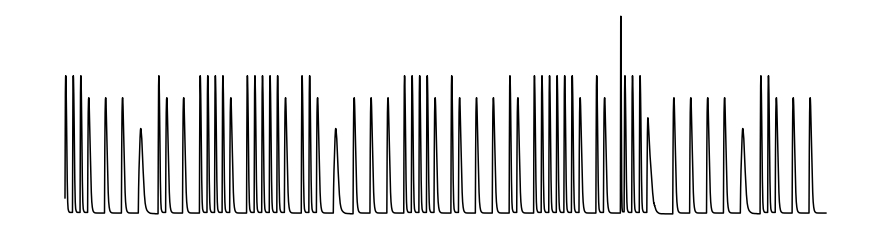

In [11]:
u = '9ccaa8fd-396a-4574-8315-ce7c1162b84d'
seq = seq_trn.df[seq_trn.df.uuid_curve == u].SEQUENCE.item()
plot_sample(seq, mean_peaks)

In [12]:
from math import exp

In [13]:
chains['pr'].log_probability(seq)

-73.79981122234054

Current Sequence
DDGHFFDEDFCCDFFDDFFCCACCAAAAAACDCC
Current Sequence
DCDFFDAAAAACCCEGCCAAAAAACCCCCCCCCD
Current Sequence
DDDFHGHFGGCCCAAAAFCFDEFFEDCCCCDDCC
Current Sequence
DFDDFFCFCCCCCCCCCCCAACCCCCDDDHFCCD
Current Sequence
CDDCAACCAAAAAACCCDDFFCCCCCCDDCFDEG
Current Sequence
FCDFGHGFFGFFFFDCDFFFF
Current Sequence
HDCCCFDGGDAGDFCCDFECCCFDDCFGDDHDDCCDFCCD
Current Sequence
EHGDDCEDDDDCCCCCDDFDCDDDFDDCCCCCCED
Current Sequence
DDCFDDCCCCDCCACDDCCCGFFFGCCCCCCCDCDF
Current Sequence
CDCDFFFFFCDFFFFDFFFFFDCCFFGD


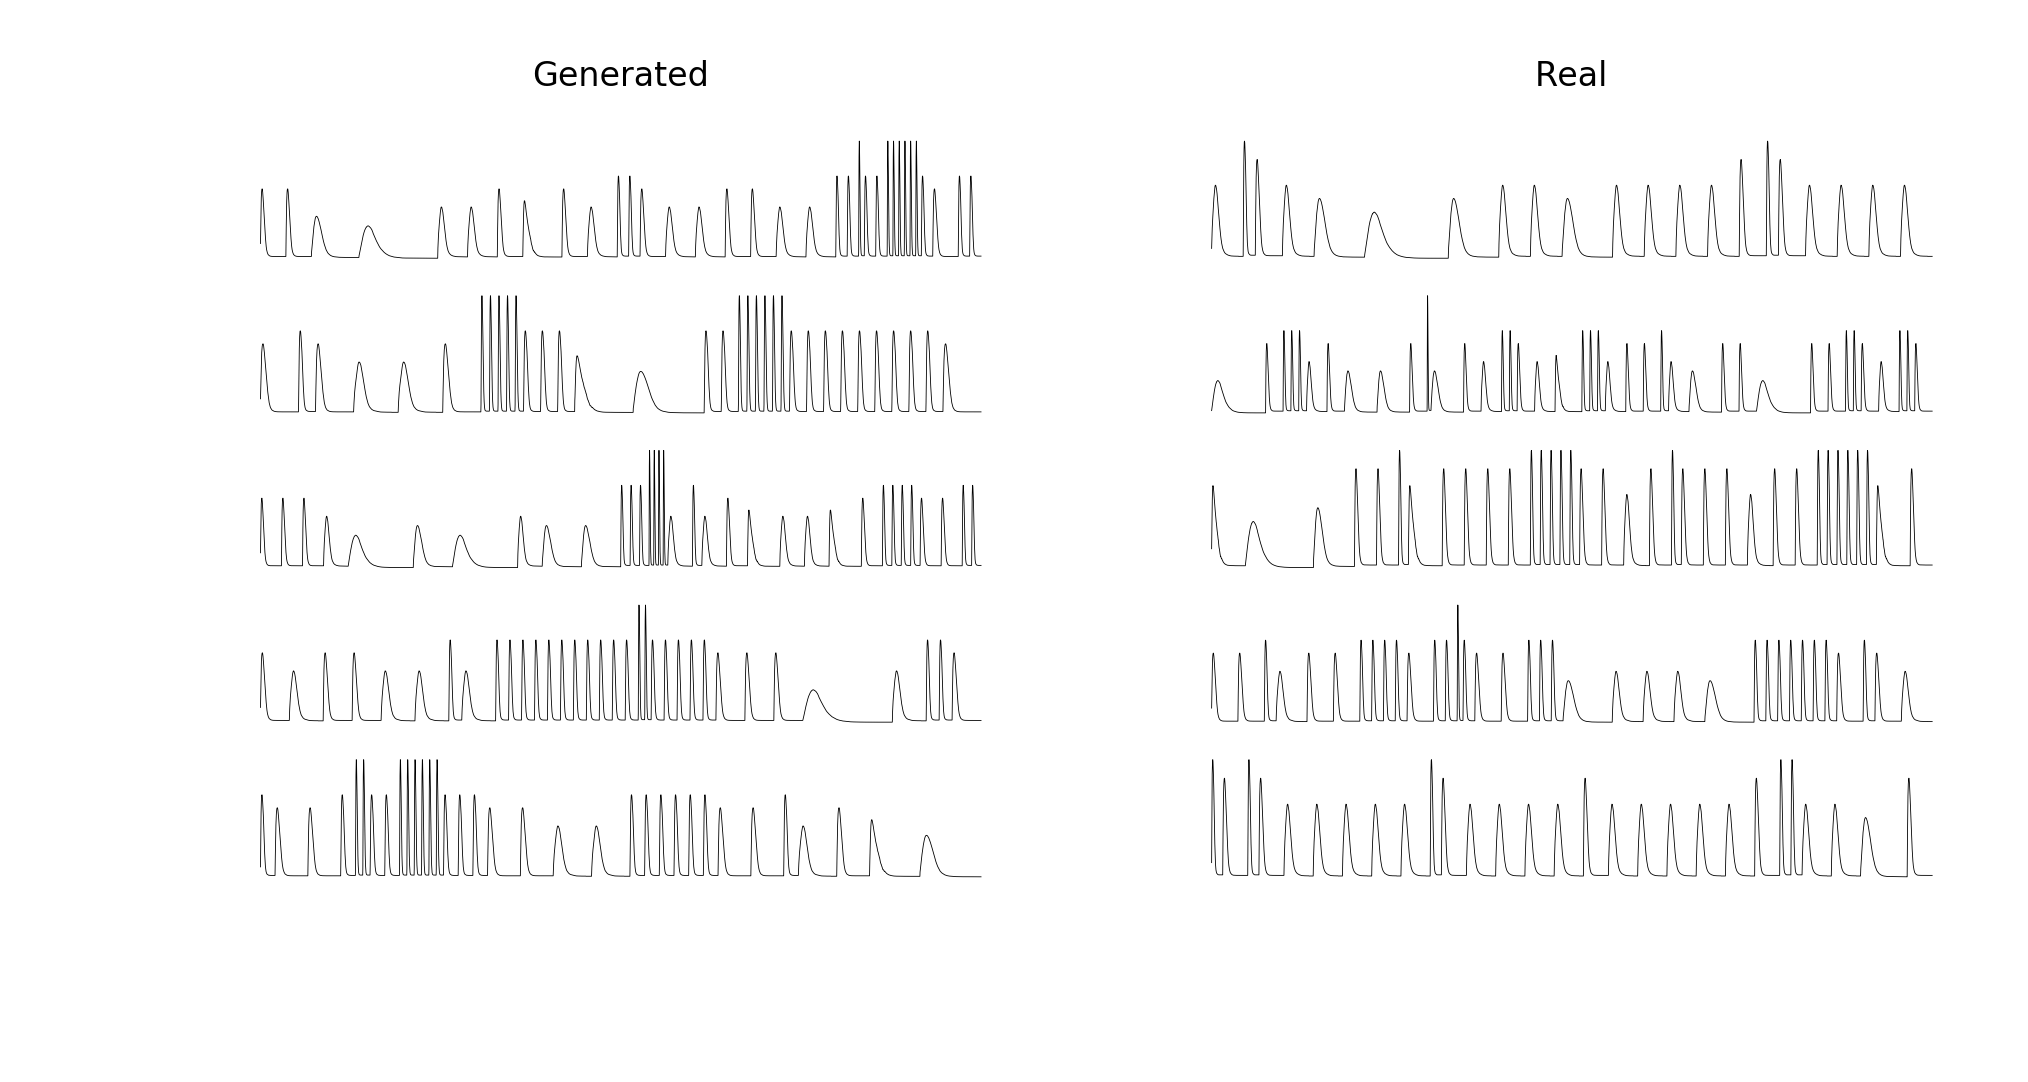

In [164]:
fig = plt.figure(figsize=(2.5*1.5,1.1*1.5), dpi=600)

nrows = 5
ncols = 2

axs = fig.subplots(nrows=nrows, ncols=ncols)

for row in range(nrows):
    plot_chosen_cell_type('pr', ax=axs[(row, 0)], linewidth=0.1)
    
axs[(0, 0)].set_title('Generated', fontdict={'fontsize': 4})
    
pr_data = seq_trn.df[seq_trn.df.cell_name == 'pr'].SEQUENCE.values
    
for row in range(nrows):
    ix = np.random.randint(0, pr_data.shape[0])
    seq = pr_data[ix]
    plot_sample(seq, mean_peaks, ax=axs[(row, 1)], linewidth=0.1)

axs[(0, 1)].set_title('Real', fontdict={'fontsize': 4})

fig.tight_layout()

In [165]:
fig.savefig('/home/kushal/Sars_stuff/Dropbox/fig_drafts/fig_2/chains_pr.png', pad_inches=0, bbox_inches='tight', dpi=1600)

Current Sequence
GDDCDDCCD
Current Sequence
CDDHFGGFF
Current Sequence
GGFHHFCGG
Current Sequence
HGCCDDHGD
Current Sequence
HGGGGHHHH
Current Sequence
HGGFGH
Current Sequence
HGG
Current Sequence
GFFEGGHHFH
Current Sequence
FGHDHGG
Current Sequence
FHHHFFF


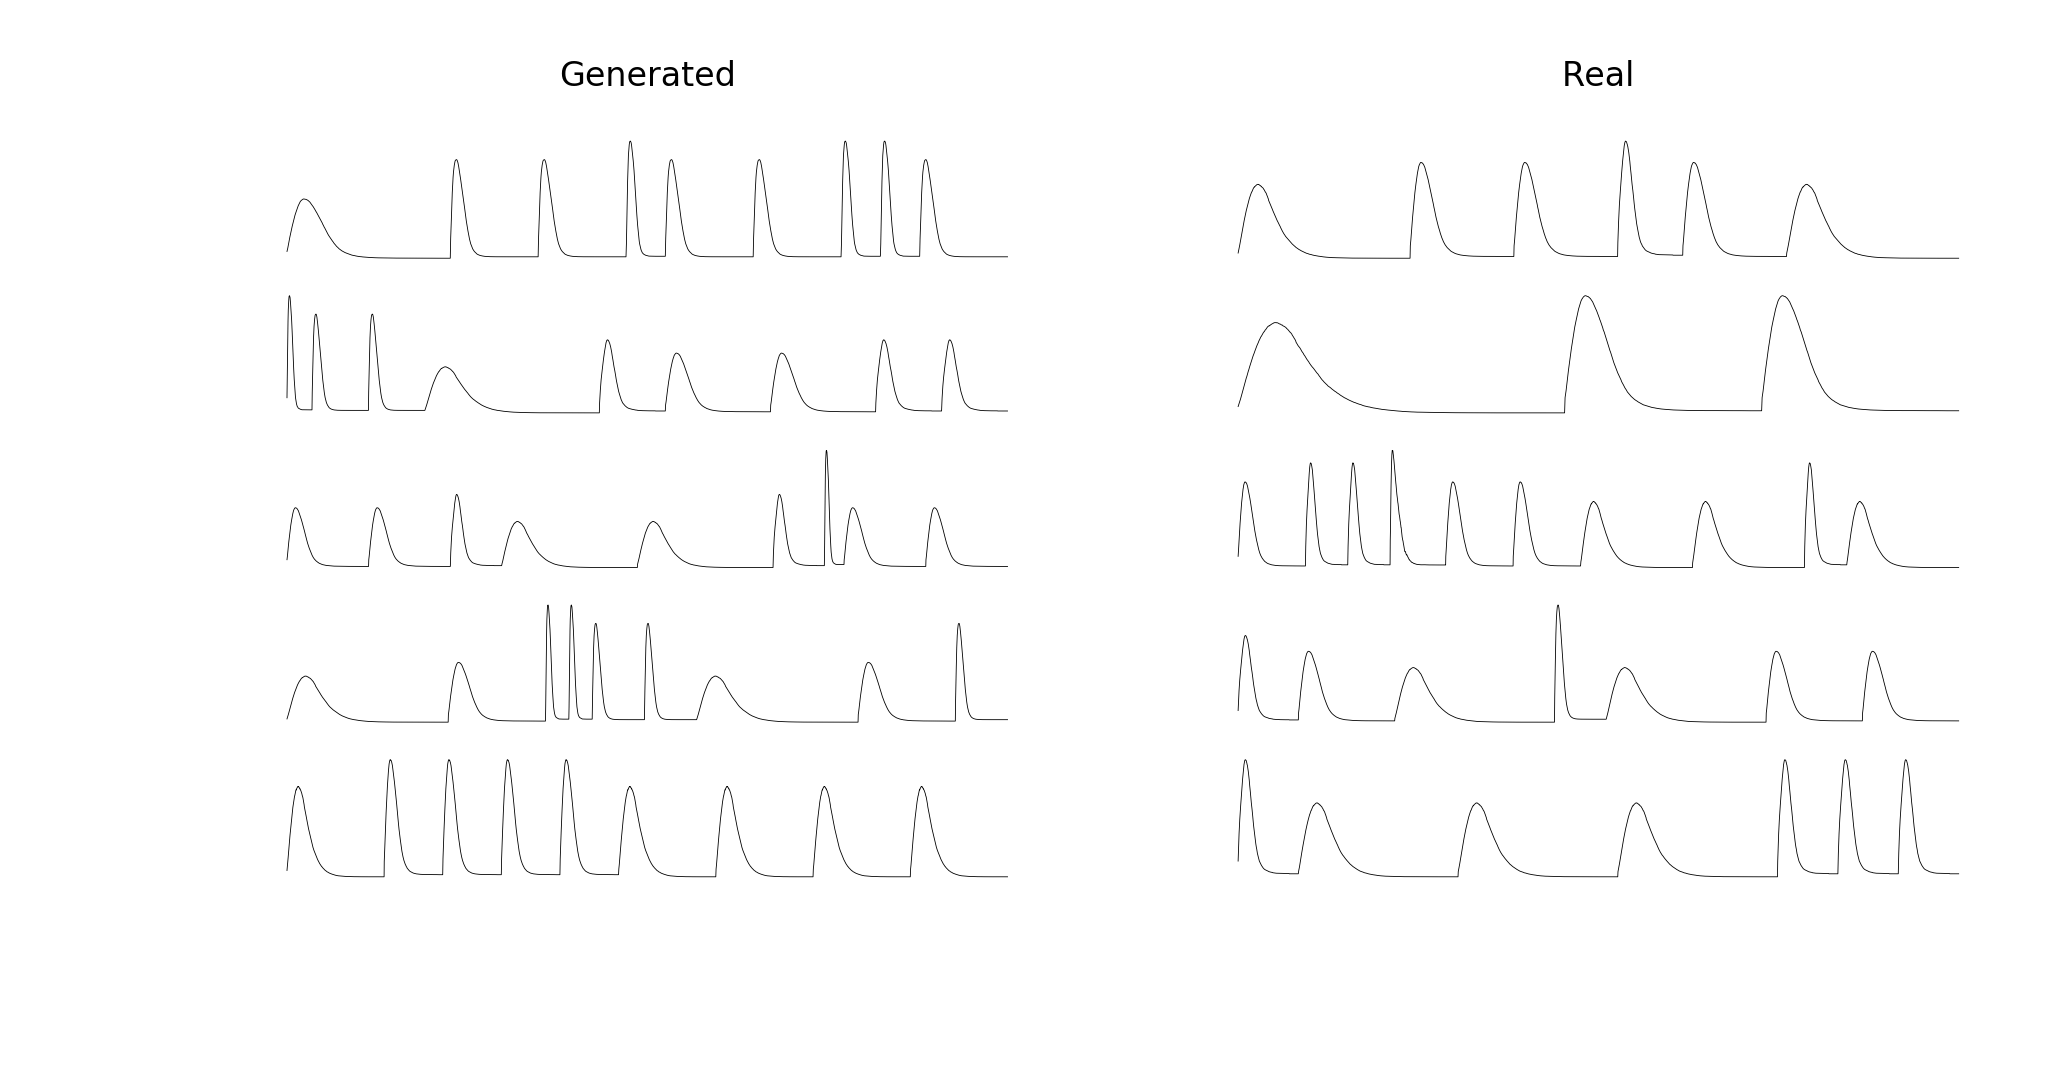

In [166]:
cell_type = 'palp'

fig = plt.figure(figsize=(2.5*1.5,1.1*1.5), dpi=600)

nrows = 5
ncols = 2

axs = fig.subplots(nrows=nrows, ncols=ncols)

for row in range(nrows):
    plot_chosen_cell_type(cell_type, ax=axs[(row, 0)], linewidth=0.1)
    
axs[(0, 0)].set_title('Generated', fontdict={'fontsize': 4})
    
pr_data = seq_trn.df[seq_trn.df.cell_name == cell_type].SEQUENCE.values
    
for row in range(nrows):
    ix = np.random.randint(0, pr_data.shape[0])
    seq = pr_data[ix]
    plot_sample(seq, mean_peaks, ax=axs[(row, 1)], linewidth=0.1)

axs[(0, 1)].set_title('Real', fontdict={'fontsize': 4})

fig.tight_layout()

In [167]:
fig.savefig('/home/kushal/Sars_stuff/Dropbox/fig_drafts/fig_2/chains_palp.png', pad_inches=0, bbox_inches='tight', dpi=1600)